# Quickstart: Modelling a surface using geological observations
This tutorial will demonstrate how to create an implicit surface representation of surfaces from a combination of orientation and location observations. 

Implicit surface representation involves finding an unknown function where $f(x,y,z)$ matches observations of the surface geometry. We generate a scalar field where the scalar value is the distance away from a reference horizon. The reference horizon is arbritary and can either be:

 * a single geological surface where the scalar field would represent the signed distance away from this surface. (above the surface positive and below negative)
 * Where multiple conformable horizons are observed the same scalar field can be used to represent these surfaces and the thickness of the layers is used to determine the relative scalar value for each surface


This tutorial will demonstrate both of these approaches for modelling a number of horizons picked from seismic data sets.

In [1]:
from FME.interpolators.piecewiselinear_interpolator import PiecewiseLinearInterpolator as PLI
from FME.supports.tet_mesh import TetMesh
from FME.modelling.features.geological_feature import GeologicalFeatureInterpolator
from FME.visualisation.model_visualisation import LavaVuModelViewer

import numpy as np
import lavavu
import matplotlib.pyplot as plt
import pandas as pd
import glob
%matplotlib inline

### Importing data
There are numerous ways to import data into python for FME. For this example there are three types of files: 

* `Dips.csv` which are the orientation observations X,Y,Z,XOrient,YOrient,ZOrient
* `_Points.csv` which are point observations of the contacts X,Y,Z,Strati
* `_Section.csv` which are section interpetations of the contacts X,Y,Z,Strati

The files can be imported into pandas dataframes. Three dataframes are created one for each of the observations types. 

In [2]:
dips = pd.read_csv('data/Dips.csv',delimiter=';')


# import all of the csv into the same dataframe use glob to find all files matching pattern
dfs = []
for f in glob.glob('data/*Points.csv'):
    dfs.append(pd.read_csv(f,delimiter=';'))
points = pd.concat(dfs,axis=0,ignore_index=True)

dfs = []
for f in glob.glob('data/*Section.csv'):
    dfs.append(pd.read_csv(f,delimiter=';'))
sections = pd.concat(dfs,axis=0,ignore_index=True)


### Setting up the interpolator
In this example we use a discrete interpolator where the implicit function is approximated using a tetrahedral mesh. The mesh needs to be built that is the same size or larger than the area of interest. 
We build the mesh by specifying the extent of the boundary box and the number of tetrahedron. 

An interpolator can be linked to this mesh.  

In [3]:
boundary_points = np.zeros((2,3))
boundary_points[0,0] = 548800
boundary_points[0,1] = 7816600
boundary_points[0,2] = -11010
boundary_points[1,0] = 552500
boundary_points[1,1] = 7822000
boundary_points[1,2] = -8400

# build the mesh
mesh = TetMesh()
mesh.setup_mesh(boundary_points, n_tetra=20000,)

# link mesh to the interpolator 
interpolator = PLI(mesh)

### Geological Features

A geological feature is any object that can be represented by a scalar field. This includes fold structural observations, stratigraphic groups of conformable layers, fault surfaces, unconformities etc.

In the next section the GeologicalFeatureInterpolator is used to build a geological feature. The abstraction of the geological feature away from the raw data or interpolator allows for easy exchange of interpolators and addition of geological structures such as faults and folds to an existing feature.

A data point can be added by calling the `add_point(position,value)` function or `add_planar_constraint(position, vector)`  

In [4]:
stratigraphy_builder = GeologicalFeatureInterpolator(
    interpolator=interpolator,
    name='stratigraphy')
solver = 'lu'
for i, r in points.iterrows():
    stratigraphy_builder.add_point([r['X'],r['Y'],r['Z']],r['Strati'])#xy[0][0],xy[1][0],z],r['value'],itype=r['itype'])
for i, r in sections.iterrows():
    stratigraphy_builder.add_point([r['X'],r['Y'],r['Z']],r['Strati'])#xy[0][0],xy[1][0],z],r['value'],itype=r['itype'])
for i, r in dips.iterrows():
    stratigraphy_builder.add_planar_constraint([r['X'],r['Y'],r['Z']],[r['OrientX'],r['OrientY'],r['OrientZ']])

    


### Run the interpolation algorithm
The interpolation algorithm can be run by calling the build function for the stratigraphy_builder.

The default options can be used or arguments can be passed to the interpolator such as the algorithm to use for solving the least squares problem or the weighting of different elements.

In most cases the default options will be acceptable, however in some cases it may be beneficial to weight the values of the regularisation terms to be higher.

The default weights for DSI are `cgw=0.1`(the constant gradient regularisation), `cpw=1.0` (value control points) and `gpw=1.0` for the gradient control points.  

#### Choice of solver
It is worthwhile noting that the choice of solver can impact the resulting solution and in some cases particular solvers will be unable to actually solve the system.
For more information on the choice of solver read the tutorial on discrete implicit modelling. The default solver is the iterative conjugate gradient method implemented in scipy sparse. Other possible choices are `lu` which calls the lower upper decomposition method from scipy sparse. 

In [5]:
stratigraphy = stratigraphy_builder.build()

109170 (109170, 4739)
Conjugate gradient converged


### Visualising results
The LavaVuModelViewer is an FME class that provides easy 3D plotting options for plotting data points and resulting implicit functions. 

The implicit function can be visualised by looking at isosurfaces of the scalar field.

```Python
viewer = LavaVuModelViewer()
viewer.plot_isosurface(feature,**kwargs)
```
Where optional kwargs can be:

* `nslices` specifying the number of regularly spaced isosurfaces
* `slices` a numpy array or list of isovalues to slice
* `isovalue` an isovalue to slice
* `paint_with` the geological feature to colour the surface with 
* `cmap` colour map for the colouring
* `normals` to plot the normal vectors to the surface
* `name` to give the surface
* `colour` the colour of the surface
* other kwargs for passing directly to lavavu

Alternatively the scalarfields can be displayed on a rectangular cuboid.
```Python
viewer.plot_model_box(boundary_points,dimensions,**kwargs)
```
Where `boundary_points` is a numpy array `[[minx,miny,minz],[maxx,maxy,maxz]]` and `dimensions` corresponds to the number of samples along each axis.

Other possible kwargs are:

* `paint_with` the geological feature to colour the box with 
* `colour` a single colour to colour the surfaces with
* `cmap` colour map for the property


**Currently this is implemented by creating 6 surfaces for the cuboid, however this means that lavavu throws warnings. The warnings do not seem to impact the results.**

The input data for the model can be visualised by calling either:
```Python
viewer.plot_data(feature,**kwargs)
```
Where both the point and vector data linked to the feature are added to the plot or by calling.
```Python
viewer.plot_vector_data(position,vector,name,**kwargs)
```
Where `position` is an array or x,y,z coordinates and vector is a similarly sized array of `vectors`. These can be extracted from a geological feature by calling.
`feature.support.interpolator.get_gradient_control()` which returns a Nx6 matrix of position and vectors.

The value data can be plotted by calling.
```Python
viewer.plot_value_data(position,value,name,**kwargs)
```
Where `position` is an array or x,y,z coordinates and value is a similarly sized vector of values. These can be extracted from a geological feature by calling.
`feature.support.interpolator.get_control_points()` which returns a Nx4 matrix of position and values.

Other possible options for plotting are to 
* plot point locations.
```Python
viewer.plot_points(position, name, **kwargs)
```
* plot a vector field using the gradient of a geological feature
```Python
viewer.plot_vector_field(feature, locations, **kwargs)
```
Where `locations` are an array of points to evaluate the gradient at, for example the barycentric coordinates. It is recommended to visualise the vectorfield at a lower resolution than the mesh otherwise it can be difficult to see the vectors. You can use numpy stepping along the array:
`locations = mesh.barycentre[::20,:]` which will sample every 20th sample in the numpy array.


Creating isosurface for 0.000000
Creating isosurface for 60.000000
Creating isosurface for 250.000000
Creating isosurface for 330.000000
Creating isosurface for 30.000000
Creating isosurface for 125.000000
Creating isosurface for 300.000000



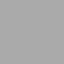

In [6]:
viewer = LavaVuModelViewer(background="white")

# determine the number of unique surfaces in the model from the input data and then calculate isosurfaces for this
unique = np.unique(stratigraphy_builder.interpolator.get_control_points()[:,3])
viewer.plot_isosurface(stratigraphy, 
                       slices=unique,  
                       colour='blue')
viewer.plot_value_data(stratigraphy.support.interpolator.get_control_points()[:,:3],
                       stratigraphy.support.interpolator.get_control_points()[:,3],
                       'val')

# add additional surfaces by defining the isovalues manuall
viewer.plot_isosurface(stratigraphy,
                       slices=[30,125,300], 
                       colour='red')
viewer.plot_vector_data(
    stratigraphy.support.interpolator.get_gradient_control()[:,:3],
    stratigraphy.support.interpolator.get_gradient_control()[:,3:],
    'grad')
viewer.plot_model_box(boundary_points,(38,55,30),
                      'box',
                     paint_with=stratigraphy,
                     cmap='prism')
viewer.interactive()

### A static image of the model


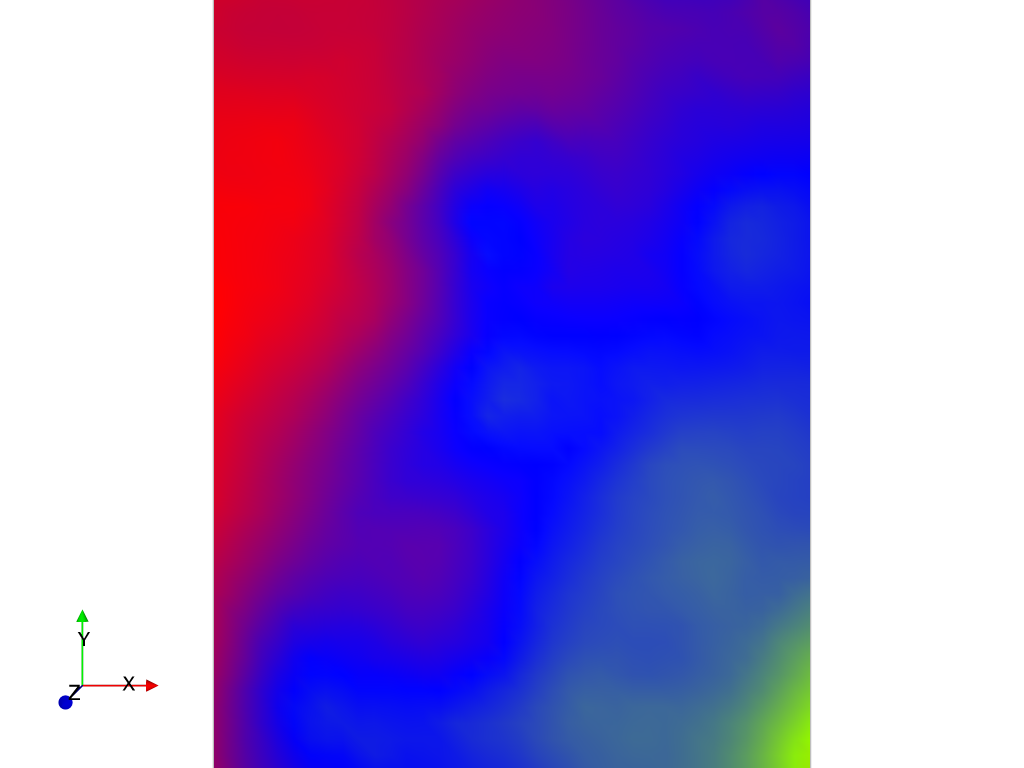

In [7]:
viewer.lv.display()

In [8]:
viewer.lv.image("~/dev/python/FME/notebooks/images/Claudius_PLI_loop.png")

'~/dev/python/FME/notebooks/images/Claudius_PLI_loop.png'